In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig
from datasets import load_dataset


c:\Users\Aman\anaconda3\envs\huggingfacev3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Loading data
df = pd.read_csv("../data/tweets.csv")

In [3]:
#Looking at first five rows of data
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Target label distribution

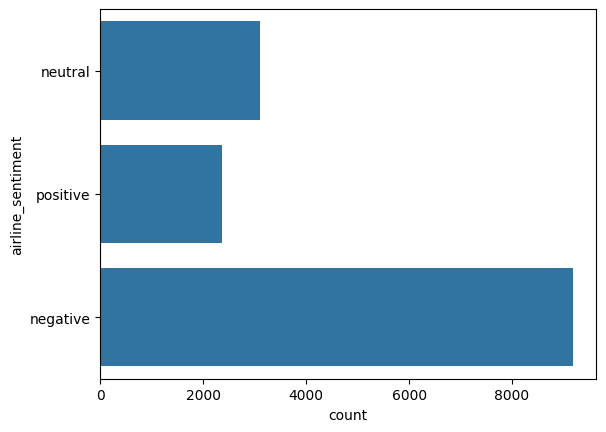

In [4]:
sns.countplot(df['airline_sentiment'])
plt.show()

* Imbalance dataset

In [5]:
df = df[['text','airline_sentiment']]

In [6]:
label_map = {"positive":1,"negative":0,"neutral":2}
df['airline_sentiment'] = df['airline_sentiment'].map(label_map)

In [7]:
df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,2
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,2
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [8]:
df2 = df
df2.columns = ['sentence','label']
df2.to_csv("processed_data/data.csv",index=None)

### Loading data in to dataset

In [9]:
from datasets import load_dataset, load_from_disk
raw_dataset = load_dataset("csv",data_files='processed_data/data.csv')

Generating train split: 14640 examples [00:00, 263633.01 examples/s]


In [10]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [11]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=2024)

In [12]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [13]:
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [14]:
def tokenize_fn(batch):
    return tokenizer(batch['sentence'],truncation=True)

In [15]:
tokenized_dataset = split.map(tokenize_fn,batched=True)

Map: 100%|██████████| 4392/4392 [00:00<00:00, 14054.34 examples/s]


In [16]:
config = AutoConfig.from_pretrained(checkpoint)

c:\Users\Aman\anaconda3\envs\huggingfacev3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [17]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.41.2",
  "vocab_size": 30522
}

In [18]:
config.id2label = {value: key for key, value in label_map.items()}
config.label2id = label_map

In [19]:
config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive",
    "2": "neutral"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "neutral": 2,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.41.2",
  "vocab_size": 30522
}

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config = config) # num_labels = 3,

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from torchinfo import summary

In [22]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 66,955,779
Trainable params: 66,955,779
Non-trainable params: 0

In [23]:
dir(TrainingArguments)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__post_init__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_n_gpu',
 '_no_sync_in_gradient_accumulation',
 '_setup_devices',
 'accelerator_config',
 'adafactor',
 'adam_beta1',
 'adam_beta2',
 'adam_epsilon',
 'auto_find_batch_size',
 'batch_eval_metrics',
 'bf16',
 'bf16_full_eval',
 'data_seed',
 'dataloader_drop_last',
 'dataloader_num_workers',
 'dataloader_persistent_workers',
 'dataloader_pin_memory',
 'dataloader_prefetch_factor',
 'ddp_backend',
 'ddp_broadcast_buffers',
 'ddp_bucket_cap_mb',
 'ddp_find_unused_parameters',
 'ddp_timeout',
 'ddp_time

In [24]:
training_args = TrainingArguments(
    output_dir = "training_dir",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    num_train_epochs = 3,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 64
    
)

c:\Users\Aman\anaconda3\envs\huggingfacev3\Lib\site-packages\transformers\training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [25]:
from sklearn.metrics import f1_score

In [26]:
def compute_metrics(logists_and_labels):
    logists, labels = logists_and_labels
    predictions = np.argmax(logists,axis=-1)
    acc = np.mean(predictions == labels)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy':acc, "f1":f1}

In [27]:
trainer = Trainer(
    model,
    training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_metrics

)

In [28]:
trainer.train()

 26%|██▌       | 501/1923 [02:06<05:42,  4.15it/s]

{'loss': 0.5303, 'grad_norm': 5.579984664916992, 'learning_rate': 3.699947997919917e-05, 'epoch': 0.78}


                                                  
 33%|███▎      | 641/1923 [03:06<04:47,  4.45it/s]

{'eval_loss': 0.4229632318019867, 'eval_accuracy': 0.8394808743169399, 'eval_f1': 0.7908009613388177, 'eval_runtime': 24.7895, 'eval_samples_per_second': 177.172, 'eval_steps_per_second': 2.783, 'epoch': 1.0}


 52%|█████▏    | 1000/1923 [04:43<03:47,  4.05it/s] 

{'loss': 0.343, 'grad_norm': 2.7393226623535156, 'learning_rate': 2.399895995839834e-05, 'epoch': 1.56}


                                                   
 67%|██████▋   | 1282/1923 [06:19<02:23,  4.46it/s]

{'eval_loss': 0.48106780648231506, 'eval_accuracy': 0.8367486338797814, 'eval_f1': 0.7792738142106557, 'eval_runtime': 24.8399, 'eval_samples_per_second': 176.812, 'eval_steps_per_second': 2.778, 'epoch': 2.0}


 78%|███████▊  | 1501/1923 [07:21<01:45,  3.99it/s]  

{'loss': 0.2403, 'grad_norm': 9.023869514465332, 'learning_rate': 1.0998439937597505e-05, 'epoch': 2.34}


                                                   
100%|██████████| 1923/1923 [09:32<00:00,  4.43it/s]

{'eval_loss': 0.5891001224517822, 'eval_accuracy': 0.8392531876138434, 'eval_f1': 0.7901715341922498, 'eval_runtime': 24.8479, 'eval_samples_per_second': 176.755, 'eval_steps_per_second': 2.777, 'epoch': 3.0}


100%|██████████| 1923/1923 [09:38<00:00,  3.33it/s]

{'train_runtime': 578.2421, 'train_samples_per_second': 53.168, 'train_steps_per_second': 3.326, 'train_loss': 0.3241674945928501, 'epoch': 3.0}


TrainOutput(global_step=1923, training_loss=0.3241674945928501, metrics={'train_runtime': 578.2421, 'train_samples_per_second': 53.168, 'train_steps_per_second': 3.326, 'total_flos': 357186082041072.0, 'train_loss': 0.3241674945928501, 'epoch': 3.0})

In [30]:
from transformers import pipeline

In [31]:
savedModel = pipeline(
    'text-classification',
    model = 'training_dir/checkpoint-1923',
    device = 0
)

In [36]:
savedModel("He has been beating him, since morning! but he loves him. This is not the love")

[{'label': 'negative', 'score': 0.9678454399108887}]

In [41]:
df=pd.DataFrame(columns=['true','pred'])
i=0
for x in split['test']:
    label = x['label']
    sentence = x['sentence']
    pred = savedModel(sentence)
    df.loc[i,"true"] = label
    df.loc[i,"pred"] = pred[0]['label']
    i+=1

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [43]:
from datasets import Dataset
dataset = Dataset.from_list(split['test'])

In [48]:
# Define a function to apply your model to each example
def predict(example):
    example['pred'] = label_map[savedModel(example['sentence'])[0]['label']]
    return example

In [49]:
# Apply the model to the dataset in parallel
dataset = dataset.map(predict, batched=False)

# Convert the dataset to a pandas DataFrame
df = dataset.to_pandas()

Map: 100%|██████████| 4392/4392 [00:45<00:00, 96.41 examples/s] 


In [51]:
df

,sentence,label,pred
0,"@united Such as deodorant, shampoo, toothpaste...",0,2
1,@AmericanAir btr trained gate agts. Im a frequ...,0,0
2,@SouthwestAir how do I go on the scavenger hun...,2,2
3,"@JetBlue messaged you, thanks",1,1
4,@united 3 times my flight has been delayed and...,0,0
...,...,...,...
4387,@united BTW is it true you have to remind flig...,0,0
4388,"@AmericanAir Considering it was past midnight,...",2,0
4389,@USAirways First class service on US 769 PHL-M...,1,1
4390,@AmericanAir I don't like making a scene but t...,0,0


In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

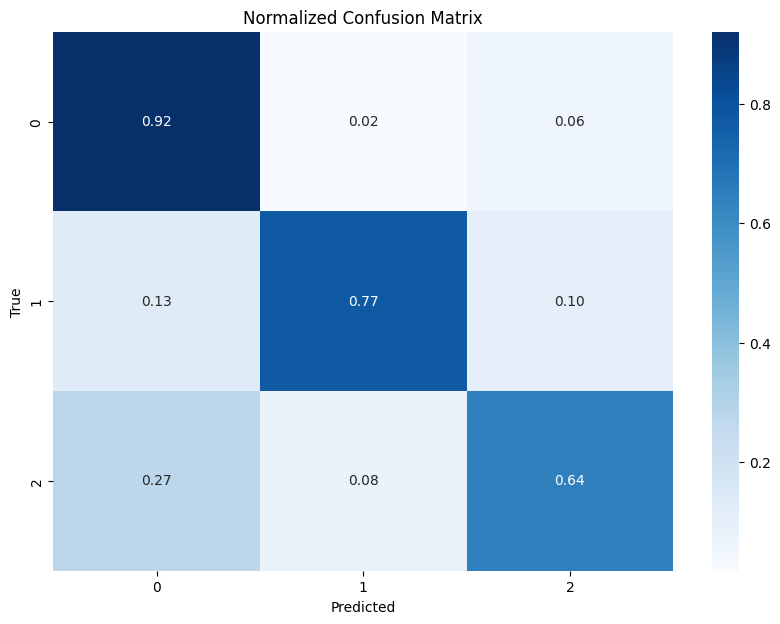

In [53]:
# Compute the confusion matrix
cm = confusion_matrix(df['label'], df['pred'], normalize='true')

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=set(df['label']), yticklabels=set(df['label']))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

* Effect of Data imbalancing is there like For Neutral Tweets (2), Model is predicting negative sentiment (0)